In [1]:
!ls -la .

total 12
drwxr-xr-x 2 root root 4096 Jul 10 09:33 .
drwxr-xr-x 5 root root 4096 Jul 10 09:33 ..
---------- 1 root root  263 Jul 10 09:33 __notebook_source__.ipynb


In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/output'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!git clone https://github.com/OnlpLab/Hebrew-Sentiment-Data.git

Cloning into 'Hebrew-Sentiment-Data'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 64 (delta 33), reused 27 (delta 15), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [4]:
!pip install transformers

In [5]:
from transformers import BertModel, BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base", num_labels=3)
model.save_pretrained("./initial_pretrained")

Downloading:   0%|          | 0.00/545k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [6]:
!ls -latr ./initial_pretrained

total 492204
drwxr-xr-x 4 root root      4096 Jul 10 09:34 ..
-rw-r--r-- 1 root root       778 Jul 10 09:34 config.json
drwxr-xr-x 2 root root      4096 Jul 10 09:34 .
-rw-r--r-- 1 root root 504002057 Jul 10 09:34 pytorch_model.bin


In [7]:
import pandas as pd
dataset = {
            "name": "Heb Poems",
            "train_path": "../input/poetry/train.csv",
            "dev_path": "../input/poetry/validation.csv",
            "test_path": "../input/poetry/test.csv",
            'classes': ['0','1']
          }

def read_data():
    train = pd.read_csv(dataset['train_path'])
    dev = pd.read_csv(dataset['dev_path'])
    test = pd.read_csv(dataset['test_path'])
    return train, dev, test
train, dev, test = read_data()
train_encodings = tokenizer(train["content"].to_list(), truncation=True, padding=True)
dev_encodings = tokenizer(dev["content"].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test["content"].to_list(), truncation=True, padding=True)
train_labels=train["p_death_israel"].to_list()
dev_labels=dev["p_death_israel"].to_list()
test_labels=test["p_death_israel"].to_list()

import torch

class HebrewPoemsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [8]:
!pip install wandb

In [9]:
from transformers import Trainer,TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)

trainer.train()
trainer.save_model("./alephbert_sentiment")

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss
10,0.996000
20,0.908900
30,0.797700
40,0.667600
50,0.675000
60,0.620400
70,0.632800
80,0.615400
90,0.572200
100,0.586700


In [10]:
!ls -latr ./alephbert_sentiment/

total 492212
drwxr-xr-x 8 root root      4096 Jul 10 09:50 ..
-rw-r--r-- 1 root root       778 Jul 10 09:50 config.json
-rw-r--r-- 1 root root      2351 Jul 10 09:50 training_args.bin
-rw-r--r-- 1 root root 504004873 Jul 10 09:50 pytorch_model.bin
drwxr-xr-x 2 root root      4096 Jul 10 09:50 .


In [11]:
import numpy as np

In [12]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [13]:
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [15]:
count_equals=0
for a,b in zip(test_dataset.labels, y_pred):
    if a==b:
        count_equals+=1
print(f"accuracy={count_equals/len(y_pred)}")

accuracy=0.897998093422307


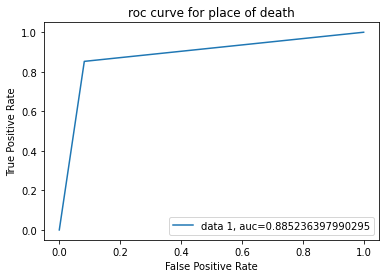

In [26]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_dataset.labels,  y_pred)
auc = metrics.roc_auc_score(test_dataset.labels, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("roc curve for place of death")
plt.show()

In [17]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(test_dataset.labels, y_pred)

(array([0.93444909, 0.81927711]),
 array([0.91780822, 0.85266458]),
 array([0.9260539 , 0.83563748]),
 array([730, 319]))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


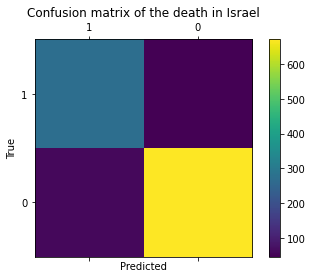

In [32]:
from sklearn.metrics import confusion_matrix
labels = [1, 0]
cm = confusion_matrix(test_dataset.labels, y_pred, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the death in Israel')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()